# Predicting the stock market using Linear Regression
In this project, we'll use past data from the S&P500 stock index to try and predict the future of the index. We'll use the older data as training set and test it on the latest data. Can we predict the stock market from the past data? Let's find out
## Reading the data

In [49]:
import pandas as pd
data = pd.read_csv('sphist.csv')
data.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883


In [50]:
data.tail()

,Date,Open,High,Low,Close,Volume,Adj Close
16585,1950-01-09,17.08,17.08,17.08,17.08,2520000.0,17.08
16586,1950-01-06,16.98,16.98,16.98,16.98,2010000.0,16.98
16587,1950-01-05,16.93,16.93,16.93,16.93,2550000.0,16.93
16588,1950-01-04,16.85,16.85,16.85,16.85,1890000.0,16.85
16589,1950-01-03,16.66,16.66,16.66,16.66,1260000.0,16.66


## Converting to datetime format
To separate our training and testing data, we need to sort our data by date. Since the date is in text format, let's convert it first to datetime then sort.

In [51]:
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(by='Date')
data.head()

,Date,Open,High,Low,Close,Volume,Adj Close
16589,1950-01-03,16.66,16.66,16.66,16.66,1260000.0,16.66
16588,1950-01-04,16.85,16.85,16.85,16.85,1890000.0,16.85
16587,1950-01-05,16.93,16.93,16.93,16.93,2550000.0,16.93
16586,1950-01-06,16.98,16.98,16.98,16.98,2010000.0,16.98
16585,1950-01-09,17.08,17.08,17.08,17.08,2520000.0,17.08


## Engineering features
The data provided in each row is the full picture of a trading day. This is not available to any trader in advance! Since we want to predict the Close price, we need to use data that is available BEFORE that day. Luckily, we have that in the form of the previous rows. Therefore, we can engineer features in each row that link the previous days to the current close. 

Thankfully, this is made easy by pandas rolling and shift functions, which allows us to take the N past rows, compute a statistic, and append it to the desired row.

In [52]:
data['5_day_avg'] = data['Close'].rolling(5).mean().shift(1)
data['365_day_avg'] = data['Close'].rolling(365).mean().shift(1)
data['5_to_365_avg'] = data['5_day_avg'] / data['365_day_avg']
data['5_day_std'] = data['Close'].rolling(5).std().shift(1)
data['365_day_std'] = data['Close'].rolling(365).std().shift(1)
data['5_to_365_std'] = data['5_day_std'] / data['365_day_std']
data.tail()

,Date,Open,High,Low,Close,Volume,Adj Close,5_day_avg,365_day_avg,5_to_365_avg,5_day_std,365_day_std,5_to_365_std
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883,2087.024023,2035.531178,1.025297,3.916109,64.370261,0.060837
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010,2090.231982,2035.914082,1.026680,7.956808,64.352527,0.123644
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117,2088.306006,2036.234356,1.025573,9.333599,64.277554,0.145208
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941,2080.456006,2036.507343,1.021580,19.599946,64.121622,0.305668
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068,2080.771973,2036.869425,1.021554,19.806136,64.058862,0.309187


## Training and testing sets
Because we computed 365 day statistics, let's restrict our data to 1951+, and split our training and testing at the year 2013

In [53]:
data = data[data["Date"] > datetime(year=1951, month=1, day=2)]
data = data.dropna(axis=0)
train = data[data["Date"] < datetime(year=2013, month=1, day=1)].copy()
test = data[data["Date"] >= datetime(year=2013, month=1, day=1)].copy()

## Linear Regression
We are now ready to predict the values from 2013 using our 1951-2012 data! Let's use the mean absolute error as our metric, and compare it to the mean close value in our testing set.

In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

features = ['5_day_avg', '365_day_avg', '5_to_365_avg', '5_day_std', '365_day_std', '5_to_365_std']
target = 'Close'
model = LinearRegression()
model.fit(train[features], train[target])
predictions = model.predict(test[features])

mae = mean_absolute_error(predictions, test[target])
close_avg = test[target].mean()
print(mae)
print(close_avg)
print(mae/close_avg*100)

16.131123821169876
1874.8903383897166
0.8603769239658242


Our mean absolute error is 0.86% of the average close value. Let's see how often we would have made money with our predictions by plotting them alongside the real value.

## Visualizing results
Let's see if we can get any insight on the goodness of our prediction using visualization.

(array([734869., 734989., 735112., 735234., 735354., 735477., 735599.,
        735719., 735842., 735964.]), <a list of 10 Text xticklabel objects>)

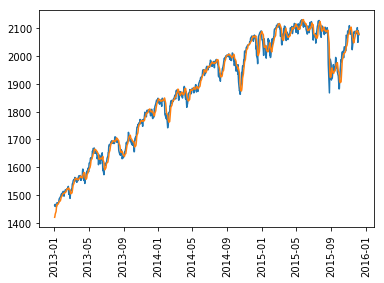

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline
test['Predictions'] = predictions
plt.plot(test['Date'], test['Close'])
plt.plot(test['Date'], test['Predictions'])

plt.xticks(rotation='vertical')

It's hard to tell. Let's zoom into a 3 month period to get a better idea of what is happening.

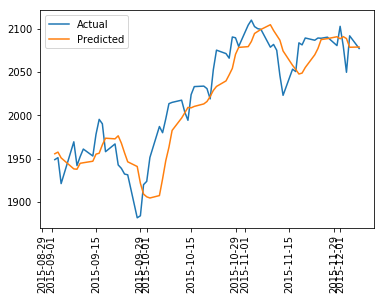

In [60]:
subset = test[test["Date"] > datetime(year=2015, month=9, day=1)].copy()
plt.plot(subset['Date'], subset['Close'], label='Actual')
plt.plot(subset['Date'], subset['Predictions'], label='Predicted')

plt.xticks(rotation='vertical')
plt.legend()

It seems that our prediction lags behind reality. Therefore, we would have to be very careful making investments off of it!
## Conclusion
Using linear regression, we were able to predict stock index with a small error. Wether that small error is sufficient to make money requires more specialized financial knowledge.